## 分析A/B测试结果

这个项目可以帮你确认你已经掌握了统计课程中涵盖的所有内容。 希望这个项目尽可能地涵盖所有内容。 祝你好运！

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

通常情况下，A/B 测试由数据分析师和数据科学家来完成。如果你在一些实践工作中遇到过这方面的问题，那学习起来就会更加游刃有余。

对于这个项目，你将要了解的是电子商务网站运行的 A/B 测试的结果。你的目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

**使用该 notebook 的时候，请同步学习课堂内容，并回答与每个问题相关的对应测试题目。** 每个课堂概念的标签对应每个题目。这样可以确保你在完成项目的过程中的方法正确，并且你最终提交的内容会更加符合标准，不必担心出现错误。最后检查的时候，请确保你的提交内容符合 [审阅标准](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) 中的所有标准。

<a id='probability'></a>
#### I - 概率

让我们先导入库，然后开始你的任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  **使用你的 dataframe 来回答课堂测试 1 中的问题。**

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
print(len(df))
#使用len可以看出共多少行
print(df.count())
#使用count可以看到每列多少（可以观察到空数据）
#可以加参数见
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.count.html
df.shape[0]

294478
user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64


294478

c. 数据集中独立用户的数量。

In [4]:
df.user_id.nunique()

290584

d. 用户转化的比例。

In [5]:
# 此处不用考虑userid重复的问题，因为同一个userid可以多次浏览网站
# 每一次都当一条数据处理
round(df.converted.mean(), 4)

0.1197

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
# 如果用筛选的方法会很慢
#print(df.head())
#df[(df['landing_page']=='new_page')&(df['group']=='treatment')].count()
# 改为df中的groupby方法（致敬任大大）
match_test = df.groupby(["group", "landing_page"]).size()
type(match_test)
# match_test.loc['control'].query('"lading_page" = "new_page"')
match_test.loc['control'].loc['new_page'] + match_test.loc['treatment'].loc['old_page']

3893


f. 是否有任何行存在缺失值？

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
# 先看下有多少这样的值
# 这里是用筛选的方法
# 检查1看左边是newpage右边不是treatment的
dismatch1 = df[(df['landing_page']=='new_page')&(df['group']!='treatment')]
dismatch1.shape[0]

1928

In [9]:
# 检查2看左边不是newpage但是右边是treatment的
dismatch2 = df[(df['landing_page']!='new_page')&(df['group']=='treatment')]
dismatch2.shape[0]

1965

In [10]:
# 计算下比率
dismatchr = (float(dismatch1.shape[0]) + float(dismatch2.shape[0])) / float(df.shape[0])
round(dismatchr,4)

0.0132

In [11]:
# 发现只有1.3%的数据是这样的，但是回头想一想，应该看dismatch的是和match的比较
# 注意复杂过滤的写法，把每个条件放到（）中
match = df[(df['landing_page']=='new_page')&(df['group']=='treatment')].shape[0]
dismatchr2 = (dismatch1.shape[0] + dismatch2.shape[0]) / match
round(dismatchr2,4)

0.0268

In [12]:
# 2.6%（上面计算出不一致的数据），不算太多，丢弃吧
# 建立df2，把符合要求的数据行过滤出来
df2 = df[((df['landing_page']=='new_page')&(df['group']=='treatment'))|
         ((df['landing_page']=='old_page')&(df['group']=='control'))].copy()
# 右侧df[()]中括号里面是过滤条件，可以符合
# 比如()&()代表与，&替换成|代表或
# 可以嵌套，如上面代码是两边先与，结果再求或
df2.shape[0]

290585

In [13]:
# 检查下是否数量相同
df2.shape[0] + dismatch1.shape[0] + dismatch2.shape[0] == df.shape[0]

True

In [14]:
# 这样检查也可以
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 使用 **df2** 与下面的单元格来回答课堂中的 **测试3** 。

a.  **df2** 中有多少唯一的 **user_id**?

In [15]:
df2['user_id'].nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [16]:
# .duplicated()就是输出重复行
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. 这个重复的  **user_id** 的行信息是什么？

In [17]:
# 同上b

d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [18]:
# 在小括弧中使用[]参数定义要判断deplicates的列
# 不加的话就是每列都重复才删除
df2.drop_duplicates(['user_id'], inplace=True)
df2.shape[0]

290584

In [19]:
# 通过dataframe的.describe()方法
# 可以得出数据的集中趋势和离散趋势的数据
df2.describe()

,user_id,converted
count,290584.000000,290584.000000
mean,788004.876222,0.119597
std,91224.735468,0.324490
min,630000.000000,0.000000
25%,709034.750000,0.000000
50%,787995.500000,0.000000
75%,866956.250000,0.000000
max,945999.000000,1.000000


`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [20]:
# 使用转化的除总数
converte_rate = df2['converted'].sum() / df2.shape[0]
# converte因为是0、1区分，所以sum就是个数
# 使用round保留4位小数
round(converte_rate,4)

0.1196

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [21]:
control_rate = df2[(df2['group'] == 'control')&(df2['converted'] == 1)].shape[0] / df2[(df2['group'] == 'control')].shape[0]
round(control_rate,4)

0.1204

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [22]:
control_rate = df2[(df2['group'] == 'treatment')&(df2['converted'] == 1)].shape[0] / df2[(df2['group'] == 'treatment')].shape[0]
round(control_rate,4)

0.1188

d. 一个用户收到新页面的概率是多少？


In [23]:
# 也可以直接筛选出来shape转成数字计算
newpage_rate = df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]
# 之后用round将结果保留4位小数
round(newpage_rate,4)

0.5001

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？在下面写出你的答案。

**在这里写出你的答案。**

In [24]:
df2.groupby("group").converted.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,145274.0,0.120386,0.325414,0.0,0.0,0.0,0.0,1.0
treatment,145310.0,0.118808,0.323564,0.0,0.0,0.0,0.0,1.0


- 两个转化率相差并不大
- 需要根据统计分析进行判断
- 将在下节II计算回答

<a id='ab_test'></a>
### II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

**在这里给出你的答案。**

<center> $ H_0:p_{new}−p_{old}\leq0 $ </center>

<center> $ H_1:p_{new}−p_{old}>0 $ </center>

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

使用下面的单元格提供这个模拟的必要内容。如果现在还没有完整的意义，不要担心，你将通过下面的问题来解决这个问题。你可以通过做课堂中的 **测试 5** 来确认你掌握了这部分内容。<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [25]:
# 如果假设是Pnew和Pold不同的转化率计算
# 丢弃 - 因为2的零假设是相同，所以要模拟零假设的情况
# new转化率
# rnew = df2[(df2['group'] == 'treatment')&(df2['converted'] == 1)].shape[0] / df2[(df2['group'] == 'treatment')].shape[0]
# round(rnew,4)
# old转化率
# rold = df2[(df2['group'] == 'control')&(df2['converted'] == 1)].shape[0] / df2[(df2['group'] == 'control')].shape[0]
# round(rold,4)

In [26]:
# “假定在零假设中，不管是新页面还是旧页面都具有等于成功率的“真”成功率”
# 因为这句话，此处模拟0假设的时候要按照两个一样去计算
# 都是收集样本的转化率
p_new = df2.converted.mean()
# print("p_new under the null is %.2f" % p_new)
round(p_new, 4)

0.1196

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [27]:
p_old = df2.converted.mean()
# print("p_new under the null is %.2f" % p_new)
round(p_old, 4)

0.1196

c.  $n_{new}$ 是多少？

In [28]:
# 筛选出new的，并且记数
nnew = df2[(df2['group'] == 'treatment')].shape[0]
nnew

145310

d.  $n_{old}$?是多少？

In [29]:
# 筛选出old的，并且记数
nold = df2[(df2['group'] == 'control')].shape[0]
nold

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [30]:
# 模拟么要使用random.choice
# ()中的参数解释
# 参数1 - 2，表明随机选择的是0，1
# 参数2 - nnew，就是上面的145310，代表抽取多少次
# 此处可以这么理解：既然是要模拟nnew的情况，那么抽取次数要和nnew相同
# 参数3 - p = [1-p_new,p_new]，就是对应参数1的两个值，各自取的概率
# rnew就是上面得出的0.1188，对应的是1的取值
new_page_converted = np.random.choice([0, 1],nnew, p = [1-p_new,p_new])
# 输出是个array
type(new_page_converted)
# 结果是numpy.ndarray，内容是由0与1组成的array
# 直接求均值就是转化率了
new_page_conr = round(new_page_converted.mean(),6)
new_page_conr

0.120315

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [31]:
old_page_converted = np.random.choice([0,1],nold, p = [1-p_old,p_old])
type(old_page_converted)
old_page_conr = round(old_page_converted.mean(),6)
old_page_conr

0.120772

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [32]:
# 因为前面两个代码框都是随机的，此处的结果随机
p_compare = round(new_page_conr - old_page_conr,6)
p_compare

-0.000457

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [35]:
# 建立p_diffs存放每次模拟抽样后的转化率
p_diffs = []
# 将上面的代码循环1万遍，得出这1万遍模拟新旧转化率的差异
for i in range(100):
    new_page_converted = np.random.choice([0,1],nnew, p = [1-p_new,p_new])
    old_page_converted = np.random.choice([0,1],nold, p = [1-p_old,p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

In [37]:
# temp for vector
# list 就不可运算
# import numpy as np
# list_array = np.array(list)
# list_array-1

In [38]:
# 将p_diffs转化为array，为了以后能用.std
p_diffs = np.array(p_diffs)
type(p_diffs)

numpy.ndarray

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？通过回答课堂上的匹配问题，确保你完全理解这里计算出的内容。

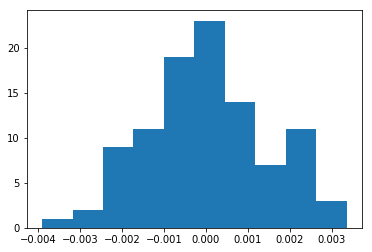

In [39]:
# 直接把p_diffs画图（列表输入，arrays输入都ok的）
plt.hist(p_diffs);

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [40]:
# 下面的3行其实是1行代码，为了不超过79个字符的规则，使用 \ 分割到下一行
# 这是的obs_diff是真实的值（从数据中推算出来的）
# obs_diffs就是根据所有数据计算出的新页面转化率和旧页面转化率的差
obs_diffs = \
df2.query('landing_page == "new_page"')['converted'].mean()- \
df2.query('landing_page == "old_page"')['converted'].mean()
# 得出obs
(p_diffs > obs_diffs).mean()

0.88

In [41]:
# 另一种方法
# 因为从p_diffs看到是正态分布
# 可以使用.normal模拟
# 参数1是0，表示中心点在0 （因为H0假设就是没有区别，所以差异为0）
# 参数2是p_diffs.std()，表示null_vals的模拟使用p_diffs的标准差
# 这样的话图形的形状就是一样的了
# 参数3是表示模拟的次数和p_diffs相同
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
# 对每个null_vals的值和真实值做比较
# 注意比较出来以后是一个有True和False的arrays
# 对它做mean（）直接求出比率
(null_vals > obs_diffs).mean()

0.88

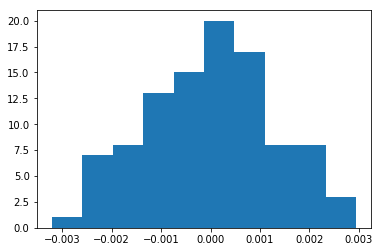

In [42]:
# 也画图看下
plt.hist(null_vals);

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？

**在这里给出你的答案。**


- 此部分因为随机每次运行结果会有一点变化
- 可以增加seed的方式
- 或者直接倒出html（这就是为什么要提交两个文件作为项目文件的原因）
- 此处应该转换为markdown框作答
- 根据上面的答案0.9061（注意因为是模拟每次可能会有点不同）
- 这个比率是模拟抽样（1万次）和真实值的对比
- 从数值上看转化率并没有区别
- 0.9061没有达到0.95的p_value统计显著性阀值

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [43]:
# 首先引入统计学模块
import statsmodels.api as sm
# 将转化了的都筛选出来
# 使用的是.query 里面是筛选的条件
con_1 = df2.query('converted =="1"')
# 测出新旧页面数量和总数量
convert_old = con_1.query('landing_page == "old_page"').shape[0]
convert_new = con_1.query('landing_page == "new_page"').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [44]:
# 引入统计学模块
import statsmodels.api as sm
# 使用.stat.proportions_ztest计算z_score
# 同时会输出p（p的概念就是：如果零假设为真，观察到统计量的概率
# 其中的3个参数
# 参数1 - 新旧页面对比的转化率 [convert_old,convert_new]
# 参数2 - 新旧页面的数量 [n_old, n_new]
# 参数3 - 计算参数延用就好
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new], alternative='smaller')
# 最后输出 z_score,p_value
z_score,p_value

(1.3109241984234394, 0.9050583127590245)

In [45]:
# 引入scipy科学计算模块
from scipy import stats
# 注意1 ：使用.ttest_ind和.ttest_rel计算相依和独立T检验
# 注意2 ：小括弧中输入比较的两个数据
# 注意3 ：会同时输出T值和P值
t, ptwo = stats.ttest_rel(sample['Con'], sample['In'])


NameError: name 'sample' is not defined

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

**在这里给出你的答案。**

- 根据得出的z-score和p-value的值：
- 检查z表格，在$ \alpha $ = 0.05 （双尾）时的值是1.96（大于才是，所以1.31无法否认零假设
- p值为0.905无法否认0假设（和0.95比较）
- 其实因为n很大（采样），只看z的就可以确定了
- 所以认为新旧页面的转化率无区别，结论与j和k中的结果一致

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

**使用逻辑回归**：因为是分类信息不是数值信息

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
pd.get_dummies(df2['landing_page']).head()

,new_page,old_page
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


In [48]:
# 根据课程中的.get_dummies一列的信息转换为两列1/0标识的信息
# 截距为1
df2['intercept'] = 1
# 此处get_dummies是将landing_page的值拆分出来，将两列值赋值给df2的新列
# 生成了2个新列 new_page old_page(用于回答后续问题)
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
# 将ab_page的两个字段应设成1/0（1表示是新页面，0表示的是旧页边）
# 之后就可以用这个列和converted做比较了（后续代码框）
# 此处使用了.map(之前导学文件中有)把后面的（）中的逐一对每个元素执行
# 执行的是 lambda x: 行内函数
# 要干的就是把x变成1，如果x=treatment； 否则变成0
df2['ab_page'] = df['group'].map(lambda x: '1' if x=="treatment" else "0")
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [49]:
df2.dtypes
# 结果表示ab_page是字符（object）

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
new_page         uint8
old_page         uint8
ab_page         object
dtype: object

In [50]:
# 转换一下
df2['ab_page'] = df2['ab_page'].astype('int64')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 9 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
new_page        290584 non-null uint8
old_page        290584 non-null uint8
ab_page         290584 non-null int64
dtypes: int64(4), object(3), uint8(2)
memory usage: 18.3+ MB


In [51]:
# 定义模型
# 使用sm.Logit(因为是新旧分类ab_page列)
# 因变量是converted
# 自变量是ab_page(intercept默认要有的)
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
# 对模型进行适配
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [52]:
results.summary()
# 使用summary2的话P为4位小数

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:21:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**

- P值为0.19，与II中的不同
- 0.19与达不到 $ \alpha $ = 0.05的显著水平
- 所以不能拒绝0假设
- 两个值不同的原因是：
    - 在II中使用的为单尾检验，在这里使用的是双尾检验
    - 检验的方向性不同，拒绝域也不相同；
    - AB测试部分假设是>=的描述，结果是单尾的
    - 逻辑回归模型中，结果是双尾的（结果中是P>|z|) ：
    - 单尾检验与双尾检验的拒绝域不相同，根据各自设定的拒绝域进行假设判定，双侧检验——|统计量| > 临界值，拒绝H0；左侧检验——统计量 < 临界值，拒绝H0；右侧检验——统计量 > 临界值，拒绝H0（H0为零假设）



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

- 数据本身的特征值并不多，增加的数量要注意
- 如果不添加特征值，会导致拟合的函数无法满足训练集，误差较大
- 如果添加过多特征值，会导致过拟合的情况，对新数据的预测结果较差

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [53]:
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [54]:
# 使用.join把country文件中的数据根据user_id进行整合
# .set_index()，on是按照那一列进行整合
# 这里两个数据都是user_id所以前后是一样的
df2 = df2.join(country.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


In [55]:
# 同样，使用虚拟变量进行变换
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1


In [56]:
df2['intercept'] = 1
lm = sm.Logit(df2['converted'],df2[['intercept','old_page']])
result_country = lm.fit()
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:21:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
old_page       0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

In [57]:
df2['intercept'] = 1
lm = sm.Logit(df2['converted'],df2[['intercept','new_page']])
result_country = lm.fit()
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        22:21:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [58]:
df2['intercept'] = 1
lm = sm.Logit(df2['converted'],df2[['intercept','CA','US']])
result_country = lm.fit()
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        22:21:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

In [59]:
# 那么再来一遍Logit分析
# 后面的参数选择的是CA、UK（根据虚拟变量那节的解释可以代表3个变量的趋势）
# 默认的斜率 = 1
df2['intercept'] = 1
# 描述模型
lm = sm.Logit(df2['converted'],df2[['intercept','CA','UK']])
# 进行适配
result_country = lm.fit()
# 输出结果
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        22:22:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [ ]:
df2['intercept'] = 1
lm = sm.Logit(df2['converted'],df2[['intercept','US','UK']])
result_country = lm.fit()
result_country.summary()

#### 上图输出解释：
- US 的p值为0.129
- UK 的p值为0.074
两个参数可以体现3个参数结合的趋势
所以结论是转化率和国家没有关系

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [60]:
df3 = df2.copy()
df3['new_UK'] = df3['new_page'] * df3['UK']
df3['new_US'] = df3['new_page'] * df3['US']
df3['intercept'] = 1
lm = sm.Logit(df2['converted'],df3[['intercept','new_UK','new_US']])
result_country = lm.fit()
result_country.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Sep 2018   Pseudo R-squ.:               1.082e-05
Time:                        22:35:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
new_UK         0.0112      0.018      0.626      0.532      -0.024       0.046
new_US        -0.0144      0.012     -1.155      0.248      -0.039       0.010
==============================================================================
"""

In [ ]:
df3['new_UK']

<a id='conclusions'></a>
## 总结

祝贺你顺利完成了该项目！

### 收集提交材料

你对你的 notebook 的状态感到满意后，应该将其保存为便于其他人阅读并查看的格式。你可以使用 __File -> Download as -> HTML (.html)__ 菜单将你的 Notebook 保存为一个 .html 文件。如果你在本地操作，并发现了一个 "找不到模块名称（No module name）" 错误，请打开终端并尝试使用 `pip install <module_name>` 安装缺少的模块（注：在模块名称中，不要包含 "<" or ">" 或任何带有期限的词汇）。

你需要同时提交原始 Notebook 和 Notebook 的HTML或PDF副本以供审阅。你不需要在提交中附带任何数据文件。如果你参考了其他网站、书籍和其他资源来帮助你解决项目中的任务，请确保记录在案。建议你在 Notebook报告末尾的 Markdown 单元格中添加 “Resources” 部分，或者可以附带一个记录你的参考资源的 `readme.txt` 文件。

### 提交项目

准备就绪后，点击“提交项目”按钮进入项目提交页面。你可以将文件以 .zip压缩文件提交，也可以链接到包含项目文件的 GitHub 存储库。如果你使用的是 GitHub，请注意，你提交的内容将是提交时的链接库的一个快照。建议你将每个项目保存在一个单独的存储库中，以避免出现混淆：如果审阅专家获取多个文件夹来代表多个项目，则他可能不明确要评估哪个项目。

我们需要一周的时间对项目进行评分，但在大多数情况下，速度要快得多。当你的提交被审阅后，你将会收到一封电子邮件。如果你在提交项目时遇到任何问题，或者想要查看提交状态，请发送电子邮件至 support@youdaxue.com。同时，你可以继续学习下一个单元的课程。